# **covid-19-in-South-Korea**

*Author*: Huey Kim

We will use [Data Science for COVID-19 dataset](https://www.kaggle.com/kimjihoo/coronavirusdataset) provided by DS4C at Kaggle.

## **List of Files**

*Encoding*: UTF-8

*   **Case.csv** (Data of COVID-19 infection cases)
*   **PatientInfo.csv** (Epidemiological data of COVID-19 patients)
*   **PatientRoute.csv** (Route data of COVID-19 patients)
*   **Region.csv** (Location and statistical data of the regions)
*   **SearchTrend.csv** (Trend data of the keywords searched in NAVER which is one of the largest portals)
*   **SeoulFloating.csv** (Data of floating population in Seoul, South Korea (from SK Telecom Big Data Hub))
*   **Time.csv** (Time series data of COVID-19 status)
*   **TimeAge.csv** (Time series data of COVID-19 status in terms of the age)
*   **TimeGender.csv** (Time series data of COVID-19 status in terms of gender)
*   **TimeProvince.csv** (Time series data of COVID-19 status in terms of the Province)
*   **Weather.csv** (Data of the weather in the regions)

### **Setting Directory Path**

In [0]:
DIR_PATH = '/content/drive/My Drive/Colab Notebooks/data/kr-corona-dataset/'

### **Setting Environment**

In [0]:
%config InlineBackend.figure_format = 'retina'

import os, copy, time, random;
import numpy as np;
import pandas as pd;
import seaborn as sns;
import matplotlib.pyplot as plt;

sns.set_style('darkgrid')
sns.set_palette('husl')

## **By Gender**

In [3]:
# Importing data: Gender
gender = pd.read_csv(os.path.join(DIR_PATH, 'TimeGender.csv'))
gender.head(2)

,date,time,sex,confirmed,deceased
0,2020-03-02,0,male,1591,13
1,2020-03-02,0,female,2621,9


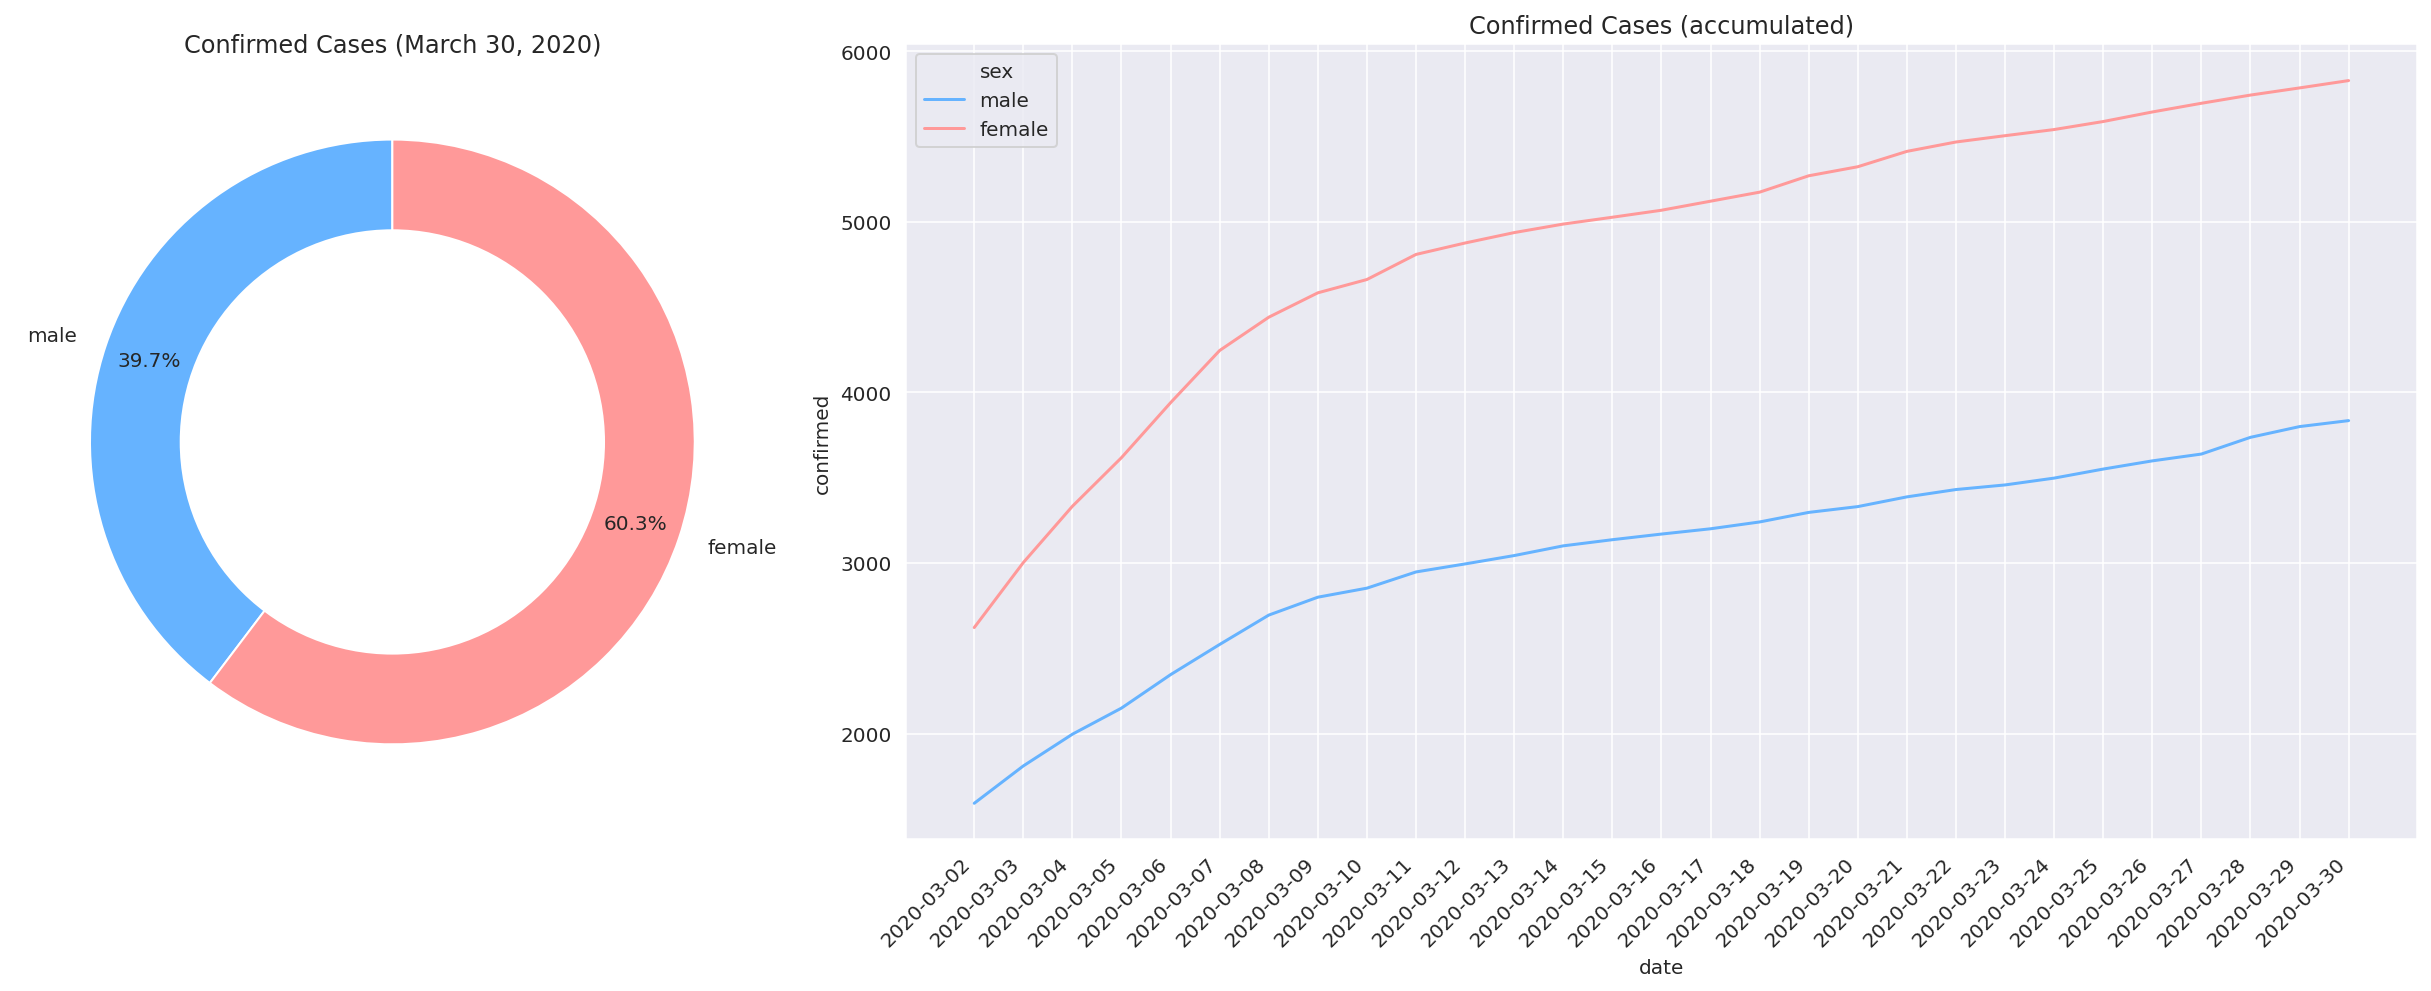

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(17, 7), gridspec_kw={'width_ratios': [1, 2]})
sns.set_palette(['#66b3ff','#ff9999'])

# Donut plot of confirmed cases by gender
ax1.title.set_text('Confirmed Cases (March 30, 2020)')
ax1.pie(gender.confirmed[-2:], labels=['male', 'female'], autopct='%.1f%%',
        startangle=90, pctdistance=0.85)
ax1.add_artist(plt.Circle((0, 0), 0.7, fc='white'))

# Change in time of confirmed cases
ax2.title.set_text('Confirmed Cases (accumulated)')
sns.lineplot(data=gender, x='date', y='confirmed', hue='sex', ax=ax2)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()

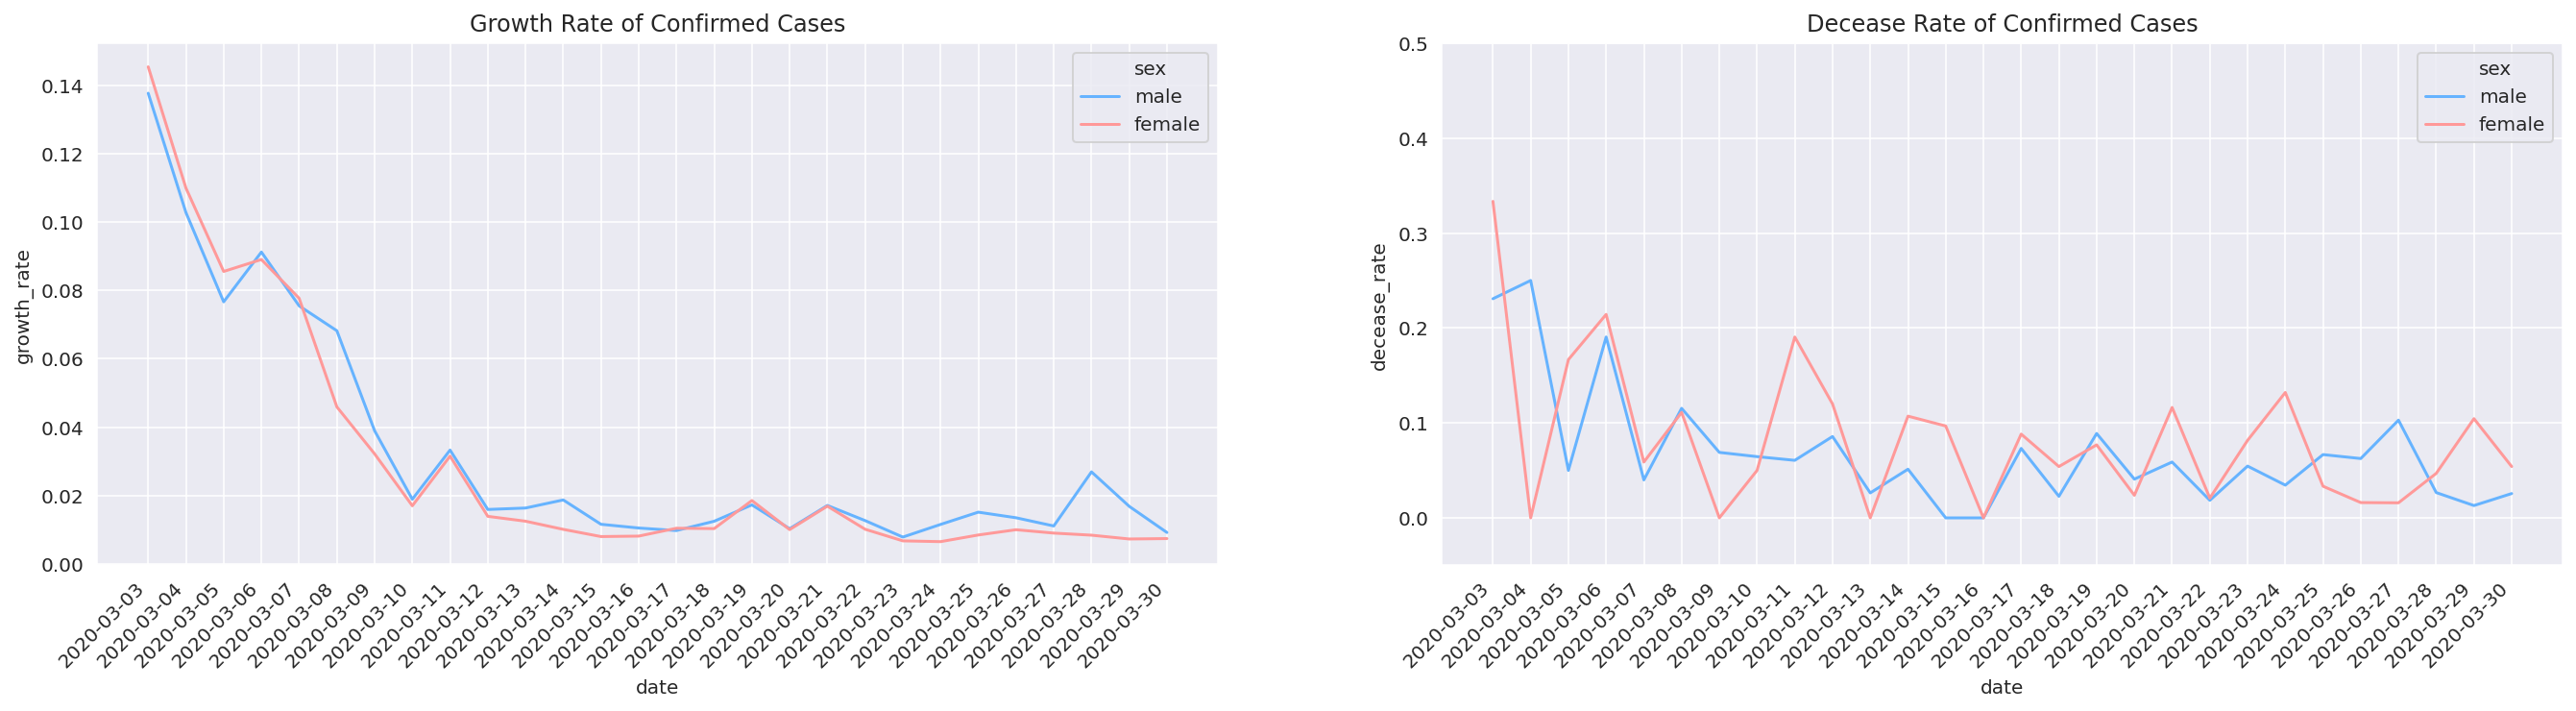

In [5]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(23, 5))

# Growth rate of confirmed cases (Index - male: even, female: odd)
ax1.title.set_text('Growth Rate of Confirmed Cases')
gender['growth_rate'] = gender.groupby('sex')[['confirmed']].pct_change()
sns.lineplot(data=gender, x='date', y='growth_rate', hue='sex', ax=ax1)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Decease rate of confirmed cases
ax2.title.set_text('Decease Rate of Confirmed Cases')
# Limiting y axis range to reduce fluctuations in graph
ax2.set(ylim=(-0.05, 0.5))
gender['decease_rate'] = gender.groupby('sex')[['deceased']].pct_change()
sns.lineplot(data=gender, x='date', y='decease_rate', hue='sex', ax=ax2)
plt.xticks(rotation=45, ha='right')

plt.show()

### **Analysis (Connection between gender & infection)**

1. More females are infected than males.
2. Growth rate of confirmed cases are similar regardless of genders.
3. Both gender show similar trend of decease rate.

### **Conclusion**

Gender **isn't** a significant factor that influences the infection rate. (No correlation)<br>
The reason why more females were infected than men might be due to geological reasons or different lifestyles.

## **By Age**

In [6]:
# Importing data: Age
age = pd.read_csv(os.path.join(DIR_PATH, 'TimeAge.csv'))
print('Unique items: {0}'.format(len(age['age'].unique())))
age.head(9)

Unique items: 9


,date,time,age,confirmed,deceased
0,2020-03-02,0,0s,32,0
1,2020-03-02,0,10s,169,0
2,2020-03-02,0,20s,1235,0
3,2020-03-02,0,30s,506,1
4,2020-03-02,0,40s,633,1
5,2020-03-02,0,50s,834,5
6,2020-03-02,0,60s,530,6
7,2020-03-02,0,70s,192,6
8,2020-03-02,0,80s,81,3


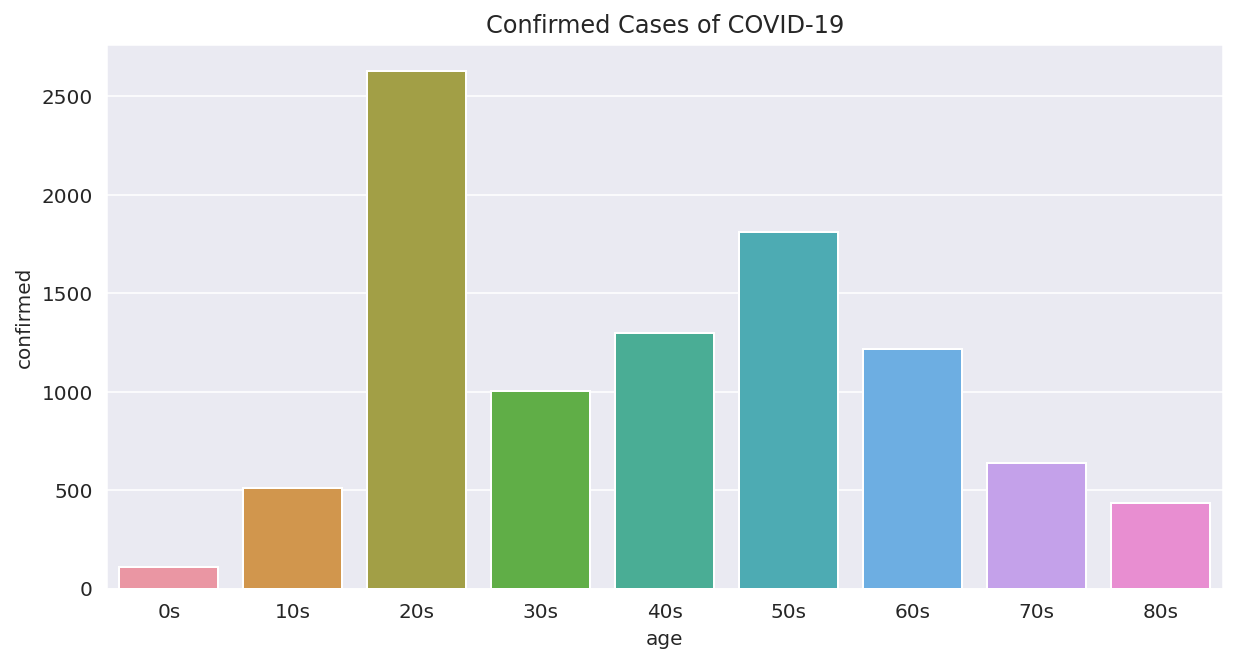

In [11]:
plt.figure(figsize=(10, 5))
plt.title('Confirmed Cases of COVID-19')
sns.barplot(data=age[-9:], x='age', y='confirmed')